# MNIST Low Precision Training Example
In this notebook, we present a quick example of how to simulate training a deep neural network in low precision with QPyTorch. The (very small) MNIST data set is used as it is trainable in about 10 minutes on a notebook computer.

## 1. Training MNIST in Floating Point

In [1]:
# import useful modules
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from qtorch.quant import Quantizer
from qtorch.optim import OptimLP
from torch.optim import SGD
from qtorch import BlockFloatingPoint, FloatingPoint, FixedPoint
from tqdm import tqdm

Record start time so we can time execution.

In [2]:
import time
start_time = time.time()

We first load the data. In this example, we will experiment with MNIST.

In [3]:
# loading data
ds = torchvision.datasets.MNIST
path = os.path.join("./data", "MNIST")
transform_train = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])
transform_test = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])
train_set = ds(path, train=True, download=True, transform=transform_train)
test_set = ds(path, train=False, download=True, transform=transform_test)
loaders = {
        'train': torch.utils.data.DataLoader(
            train_set,
            batch_size=64,
            shuffle=True,
            num_workers=1,
            pin_memory=True
        ),
        'test': torch.utils.data.DataLoader(
            test_set,
            batch_size=64,
            num_workers=1,
            pin_memory=True
        )
}

0it [00:00, ?it/s]

9920512it [00:01, 6262308.10it/s]                             


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 93838.69it/s]            
0it [00:00, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1816970.43it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 44688.33it/s]            


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


We then define the quantization setting we are going to use. We define a low and high precision format for different parts of the computation.

In [4]:
# define two floating point formats
lowp = FixedPoint(wl=8, fl=7)
highp = FloatingPoint(exp=8, man=7)  # this is bfloat16

# define quantization functions
weight_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")
grad_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
momentum_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
acc_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")

# define a lambda function so that the Quantizer module can be duplicated easily
act_error_quant = lambda : Quantizer(forward_number=lowp, backward_number=lowp,
                        forward_rounding="nearest", backward_rounding="nearest")

Next, we define a simple LeNet network. 

In [5]:
# let's define the model we are using
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



We now use the low-precision optimizer wrapper to help define the quantization of weight, gradient, momentum, and gradient accumulator.

In [6]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
mxepochs = 10

We can reuse common training scripts without any extra codes to handle quantization.

In [7]:
def run_epoch(loader, model, criterion, optimizer=None, phase="train"):
    assert phase in ["train", "eval"], "invalid running phase"
    loss_sum = 0.0
    correct = 0.0

    if phase=="train": model.train()
    elif phase=="eval": model.eval()

    ttl = 0
    with torch.autograd.set_grad_enabled(phase=="train"):
        for i, (input, target) in tqdm(enumerate(loader), total=len(loader)):
            input = input.to(device=device)
            target = target.to(device=device)
            output = model(input)
            loss = criterion(output, target)
            loss_sum += loss.cpu().item() * input.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            ttl += input.size()[0]

            if phase=="train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    correct = correct.cpu().item()
    return {
        'loss': loss_sum / float(ttl),
        'accuracy': correct / float(ttl) * 100.0,
    }

Run the training in floating point.

In [8]:
for epoch in range(mxepochs):
    fp_train_res = run_epoch(loaders['train'], model, F.cross_entropy,
                            optimizer=optimizer, phase="train")
    fp_test_res = run_epoch(loaders['test'], model, F.cross_entropy,
                            optimizer=optimizer, phase="eval")
    print('epoch', epoch)
    print(fp_train_res)
    print(fp_test_res)

100%|██████████| 157/157 [00:01<00:00, 80.69it/s]


epoch 0
{'loss': 0.1308977189583083, 'accuracy': 95.93}
{'loss': 0.042565385287348184, 'accuracy': 98.55000000000001}


100%|██████████| 157/157 [00:01<00:00, 80.58it/s]

epoch 1
{'loss': 0.04677531966028425, 'accuracy': 98.535}
{'loss': 0.03154972235925961, 'accuracy': 99.05000000000001}



100%|██████████| 157/157 [00:01<00:00, 79.94it/s]

epoch 2
{'loss': 0.03022077413726365, 'accuracy': 99.06666666666666}
{'loss': 0.03574472720858175, 'accuracy': 98.78}



100%|██████████| 157/157 [00:01<00:00, 86.33it/s]

epoch 3
{'loss': 0.02480003566315475, 'accuracy': 99.25500000000001}
{'loss': 0.028121386936711498, 'accuracy': 99.22}



100%|██████████| 157/157 [00:01<00:00, 85.65it/s]

epoch 4
{'loss': 0.018793671909853583, 'accuracy': 99.39666666666666}
{'loss': 0.03160598775590879, 'accuracy': 99.08}



100%|██████████| 157/157 [00:01<00:00, 85.04it/s]

epoch 5
{'loss': 0.01532717491145595, 'accuracy': 99.52}
{'loss': 0.03527631715072057, 'accuracy': 99.00999999999999}



100%|██████████| 157/157 [00:01<00:00, 84.03it/s]

epoch 6
{'loss': 0.013341881047098044, 'accuracy': 99.53166666666667}
{'loss': 0.02981691688554347, 'accuracy': 99.2}



100%|██████████| 157/157 [00:01<00:00, 83.11it/s]

epoch 7
{'loss': 0.011727292320467434, 'accuracy': 99.62166666666667}
{'loss': 0.031908917427789674, 'accuracy': 99.14}



100%|██████████| 157/157 [00:01<00:00, 82.74it/s]

epoch 8
{'loss': 0.011318152816041403, 'accuracy': 99.625}
{'loss': 0.025136449154952424, 'accuracy': 99.26}



100%|██████████| 157/157 [00:02<00:00, 76.22it/s]

epoch 9
{'loss': 0.005531758832290992, 'accuracy': 99.815}
{'loss': 0.02678031347261376, 'accuracy': 99.18}


## 2. Block Floating Point Inference

Now do it with quantized arithmetic. We first define the data types

In [9]:
# define two floating point formats
lowp = BlockFloatingPoint(wl=8, dim=-1)   
highp = FloatingPoint(exp=8, man=7)      # this is bfloat16

# define quantization functions
weight_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")
grad_quant = Quantizer(forward_number=lowp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
momentum_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="stochastic")
acc_quant = Quantizer(forward_number=highp, backward_number=None,
                        forward_rounding="nearest", backward_rounding="nearest")

# define a lambda function so that the Quantizer module can be duplicated easily
act_error_quant = lambda : Quantizer(forward_number=lowp, backward_number=lowp,
                        forward_rounding="nearest", backward_rounding="nearest")

Now we define the network. In the definition, we insert quantization module after every convolution layer. Note that the quantization of weight, gradient, momentum, and gradient accumulator are not handled here.

In [10]:
# let's define the model we are using
class lp_Net(nn.Module):
    def __init__(self, quant=None):
        super(lp_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.quant = quant()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.quant(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.quant(x)
        x = F.relu(self.conv2(x))
        x = self.quant(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.quant(x)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.quant(x)
        x = self.fc2(x)
        x = self.quant(x)
        return F.log_softmax(x, dim=1)

In [11]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
model = lp_Net(act_error_quant).to(device)
optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
lp_optimizer = OptimLP(optimizer,
                    weight_quant=weight_quant,
                    grad_quant=grad_quant,
                    momentum_quant=momentum_quant,
                    acc_quant=acc_quant
)
for epoch in range(mxepochs):
    train_res = run_epoch(loaders['train'], model, F.cross_entropy,
                                optimizer=lp_optimizer, phase="train")
    test_res = run_epoch(loaders['test'], model, F.cross_entropy,
                                optimizer=lp_optimizer, phase="eval")
    print('epoch', epoch)
    print(train_res)
    print(test_res)

100%|██████████| 157/157 [24:56<00:00,  9.53s/it]  

epoch 0
{'loss': 0.16407857935912906, 'accuracy': 95.12}
{'loss': 0.05217512269823346, 'accuracy': 98.47}



100%|██████████| 157/157 [00:05<00:00, 28.70it/s]

epoch 1
{'loss': 0.05315214948949094, 'accuracy': 98.43666666666667}
{'loss': 0.05982327702050097, 'accuracy': 98.09}



100%|██████████| 157/157 [1:03:58<00:00, 24.45s/it]   

epoch 2
{'loss': 0.03567801484420585, 'accuracy': 98.96333333333334}
{'loss': 0.039939903816120934, 'accuracy': 98.77}



100%|██████████| 157/157 [00:05<00:00, 26.17it/s]

epoch 3
{'loss': 0.03066425574516567, 'accuracy': 99.05833333333334}
{'loss': 0.03789150432195165, 'accuracy': 98.91}



100%|██████████| 157/157 [00:05<00:00, 26.99it/s]

epoch 4
{'loss': 0.027128450920886827, 'accuracy': 99.16666666666667}
{'loss': 0.028321706962160534, 'accuracy': 99.14}



100%|██████████| 157/157 [00:05<00:00, 28.16it/s]

epoch 5
{'loss': 0.02014389256016584, 'accuracy': 99.37}
{'loss': 0.03703302975729457, 'accuracy': 98.94}



100%|██████████| 157/157 [00:05<00:00, 28.65it/s]

epoch 6
{'loss': 0.016683798395913132, 'accuracy': 99.48166666666667}
{'loss': 0.034652585619868476, 'accuracy': 99.07000000000001}



100%|██████████| 157/157 [00:05<00:00, 28.11it/s]

epoch 7
{'loss': 0.014210890785272932, 'accuracy': 99.52}
{'loss': 0.043973687187483304, 'accuracy': 98.74000000000001}



100%|██████████| 157/157 [00:05<00:00, 27.28it/s]

epoch 8
{'loss': 0.011289743180039417, 'accuracy': 99.62}
{'loss': 0.04671122122440574, 'accuracy': 98.71}



100%|██████████| 157/157 [00:05<00:00, 28.14it/s]

epoch 9
{'loss': 0.013213940876281898, 'accuracy': 99.57333333333334}
{'loss': 0.028975760500422984, 'accuracy': 99.14}


## 3. Accuracy vs wordlength

First include some libraries

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Compute NN accuracy vs wordlength

In [13]:
res = []
(minp, maxp) = (1,8)
for wl in range(minp, maxp+1):
    # define two floating point formats
    lowp = BlockFloatingPoint(wl=8, dim=-1)   
    highp = FloatingPoint(exp=8, man=7)      # this is bfloat16

    # define quantization functions
    weight_quant = Quantizer(forward_number=lowp, backward_number=None,
                            forward_rounding="nearest", backward_rounding="nearest")
    grad_quant = Quantizer(forward_number=lowp, backward_number=None,
                            forward_rounding="nearest", backward_rounding="stochastic")
    momentum_quant = Quantizer(forward_number=highp, backward_number=None,
                            forward_rounding="nearest", backward_rounding="stochastic")
    acc_quant = Quantizer(forward_number=highp, backward_number=None,
                            forward_rounding="nearest", backward_rounding="nearest")

    # define a lambda function so that the Quantizer module can be duplicated easily
    act_error_quant = lambda : Quantizer(forward_number=lowp, backward_number=lowp,
                            forward_rounding="nearest", backward_rounding="nearest")
    use_cuda = False
    device = torch.device("cuda" if use_cuda else "cpu")
    model = lp_Net(act_error_quant).to(device)
    optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
    lp_optimizer = OptimLP(optimizer,
                        weight_quant=weight_quant,
                        grad_quant=grad_quant,
                        momentum_quant=momentum_quant,
                        acc_quant=acc_quant
    )
    for epoch in range(mxepochs):
        train_res = run_epoch(loaders['train'], model, F.cross_entropy,
                                    optimizer=lp_optimizer, phase="train")
        test_res = run_epoch(loaders['test'], model, F.cross_entropy,
                                    optimizer=lp_optimizer, phase="eval")
        print('wl', wl, 'epoch', epoch)
        print(train_res)
        print(test_res)
        
    # make scatterplot
    res.append((wl, test_res['accuracy']))
print(res)

100%|██████████| 157/157 [00:05<00:00, 28.54it/s]

wl 1 epoch 0
{'loss': 0.13334788675132828, 'accuracy': 95.77833333333334}
{'loss': 0.06134780429769307, 'accuracy': 97.89}



100%|██████████| 157/157 [00:05<00:00, 28.40it/s]

wl 1 epoch 1
{'loss': 0.04270939496687303, 'accuracy': 98.69333333333333}
{'loss': 0.042036952568404375, 'accuracy': 98.63}



100%|██████████| 157/157 [00:05<00:00, 28.77it/s]

wl 1 epoch 2
{'loss': 0.028281971835077274, 'accuracy': 99.10666666666667}
{'loss': 0.043777026345254856, 'accuracy': 98.6}



100%|██████████| 157/157 [00:05<00:00, 28.43it/s]

wl 1 epoch 3
{'loss': 0.021018055758244978, 'accuracy': 99.33166666666666}
{'loss': 0.03138738865750493, 'accuracy': 99.06}



100%|██████████| 157/157 [00:05<00:00, 27.96it/s]

wl 1 epoch 4
{'loss': 0.0184226861750319, 'accuracy': 99.41499999999999}
{'loss': 0.027743495805436395, 'accuracy': 99.14}



100%|██████████| 157/157 [00:05<00:00, 26.91it/s]

wl 1 epoch 5
{'loss': 0.013569299505626744, 'accuracy': 99.55666666666667}
{'loss': 0.028604169275829917, 'accuracy': 99.17}



100%|██████████| 157/157 [00:08<00:00, 18.55it/s]

wl 1 epoch 6
{'loss': 0.008265201491991562, 'accuracy': 99.76}
{'loss': 0.029302618485226414, 'accuracy': 99.25}



100%|██████████| 157/157 [00:05<00:00, 28.31it/s]

wl 1 epoch 7
{'loss': 0.008218365344535171, 'accuracy': 99.72999999999999}
{'loss': 0.033778072384646654, 'accuracy': 99.11}



100%|██████████| 157/157 [00:05<00:00, 26.29it/s]

wl 1 epoch 8
{'loss': 0.008889271622902985, 'accuracy': 99.71666666666667}
{'loss': 0.02455058194215526, 'accuracy': 99.24}



100%|██████████| 157/157 [00:06<00:00, 26.17it/s]

wl 1 epoch 9
{'loss': 0.007080459472027481, 'accuracy': 99.77333333333334}
{'loss': 0.029613272997544116, 'accuracy': 99.19}



100%|██████████| 157/157 [00:05<00:00, 27.68it/s]

wl 2 epoch 0
{'loss': 0.14125817596179743, 'accuracy': 95.59}
{'loss': 0.04629960912337992, 'accuracy': 98.58}



100%|██████████| 157/157 [00:05<00:00, 28.03it/s]

wl 2 epoch 1
{'loss': 0.04694550960405419, 'accuracy': 98.59166666666667}
{'loss': 0.04844304312095046, 'accuracy': 98.58}



100%|██████████| 157/157 [00:05<00:00, 26.67it/s]

wl 2 epoch 2
{'loss': 0.032675127061860015, 'accuracy': 98.95166666666667}
{'loss': 0.03632372691557975, 'accuracy': 98.89}



100%|██████████| 157/157 [00:06<00:00, 24.89it/s]

wl 2 epoch 3
{'loss': 0.027445970804380097, 'accuracy': 99.13333333333333}
{'loss': 0.05027060392289422, 'accuracy': 98.56}



100%|██████████| 157/157 [00:05<00:00, 26.39it/s]

wl 2 epoch 4
{'loss': 0.021861558027906965, 'accuracy': 99.28166666666667}
{'loss': 0.03428227720579453, 'accuracy': 98.98}



100%|██████████| 157/157 [00:05<00:00, 27.07it/s]

wl 2 epoch 5
{'loss': 0.018113554227584972, 'accuracy': 99.46333333333334}
{'loss': 0.04621957076354884, 'accuracy': 98.67}



100%|██████████| 157/157 [00:05<00:00, 27.12it/s]

wl 2 epoch 6
{'loss': 0.010864415659190853, 'accuracy': 99.66333333333334}
{'loss': 0.031045680089848246, 'accuracy': 99.17}



100%|██████████| 157/157 [00:05<00:00, 27.62it/s]

wl 2 epoch 7
{'loss': 0.013055562537382746, 'accuracy': 99.58}
{'loss': 0.03377062855189215, 'accuracy': 99.13}



100%|██████████| 157/157 [00:05<00:00, 28.30it/s]

wl 2 epoch 8
{'loss': 0.008897409653912959, 'accuracy': 99.71166666666666}
{'loss': 0.03723939739828238, 'accuracy': 99.15}



100%|██████████| 157/157 [00:05<00:00, 28.19it/s]

wl 2 epoch 9
{'loss': 0.007316067092315158, 'accuracy': 99.78}
{'loss': 0.039603882824043285, 'accuracy': 99.15}



100%|██████████| 157/157 [00:05<00:00, 28.57it/s]

wl 3 epoch 0
{'loss': 0.1586423158235848, 'accuracy': 95.11}
{'loss': 0.05809144135154784, 'accuracy': 98.2}



100%|██████████| 157/157 [00:05<00:00, 28.26it/s]

wl 3 epoch 1
{'loss': 0.04921351001504809, 'accuracy': 98.46000000000001}
{'loss': 0.035853267348650845, 'accuracy': 98.96000000000001}



100%|██████████| 157/157 [00:05<00:00, 28.79it/s]

wl 3 epoch 2
{'loss': 0.03542543956787946, 'accuracy': 98.91666666666666}
{'loss': 0.03731694094113191, 'accuracy': 98.81}



100%|██████████| 157/157 [00:05<00:00, 28.73it/s]

wl 3 epoch 3
{'loss': 0.02767616901899067, 'accuracy': 99.125}
{'loss': 0.042414341275478364, 'accuracy': 98.77}



100%|██████████| 157/157 [00:05<00:00, 28.57it/s]

wl 3 epoch 4
{'loss': 0.024438041069191726, 'accuracy': 99.24166666666666}
{'loss': 0.03484952844238433, 'accuracy': 98.86}



100%|██████████| 157/157 [00:05<00:00, 28.55it/s]

wl 3 epoch 5
{'loss': 0.018900436472966492, 'accuracy': 99.39166666666667}
{'loss': 0.030179040141118458, 'accuracy': 99.1}



100%|██████████| 157/157 [00:05<00:00, 28.71it/s]

wl 3 epoch 6
{'loss': 0.014941542964937495, 'accuracy': 99.50666666666666}
{'loss': 0.034545161798192565, 'accuracy': 99.00999999999999}



100%|██████████| 157/157 [00:05<00:00, 28.55it/s]

wl 3 epoch 7
{'loss': 0.017794470219430515, 'accuracy': 99.40833333333333}
{'loss': 0.040656762142108345, 'accuracy': 98.88}



100%|██████████| 157/157 [00:05<00:00, 28.27it/s]

wl 3 epoch 8
{'loss': 0.01284305412697431, 'accuracy': 99.56166666666667}
{'loss': 0.03908895369017373, 'accuracy': 99.1}



100%|██████████| 157/157 [00:05<00:00, 28.57it/s]

wl 3 epoch 9
{'loss': 0.012540095031324503, 'accuracy': 99.60166666666666}
{'loss': 0.038986298161177546, 'accuracy': 98.98}



100%|██████████| 157/157 [00:05<00:00, 28.71it/s]

wl 4 epoch 0
{'loss': 0.14067210337768, 'accuracy': 95.61}
{'loss': 0.05184451726414263, 'accuracy': 98.49}



100%|██████████| 157/157 [00:08<00:00, 23.52it/s]

wl 4 epoch 1
{'loss': 0.047925641147978607, 'accuracy': 98.53666666666666}
{'loss': 0.035944996472168714, 'accuracy': 98.9}



100%|██████████| 157/157 [00:06<00:00, 22.93it/s]

wl 4 epoch 2
{'loss': 0.03352164667006582, 'accuracy': 98.92166666666667}
{'loss': 0.033502753777161706, 'accuracy': 99.00999999999999}



100%|██████████| 157/157 [00:08<00:00, 18.39it/s]

wl 4 epoch 3
{'loss': 0.026255223176030754, 'accuracy': 99.17833333333334}
{'loss': 0.051087847707315816, 'accuracy': 98.57000000000001}



100%|██████████| 157/157 [00:06<00:00, 25.93it/s]


wl 4 epoch 4
{'loss': 0.018667078641503274, 'accuracy': 99.41666666666666}
{'loss': 0.03606344955860295, 'accuracy': 98.99}


100%|██████████| 157/157 [00:07<00:00, 20.50it/s]

wl 4 epoch 5
{'loss': 0.016645710116789753, 'accuracy': 99.47500000000001}
{'loss': 0.028157114558067405, 'accuracy': 99.15}



100%|██████████| 157/157 [00:06<00:00, 25.95it/s]

wl 4 epoch 6
{'loss': 0.012441294835284741, 'accuracy': 99.60166666666666}
{'loss': 0.036929081193136516, 'accuracy': 98.83999999999999}



100%|██████████| 157/157 [00:06<00:00, 25.48it/s]

wl 4 epoch 7
{'loss': 0.012645302525857308, 'accuracy': 99.57666666666667}
{'loss': 0.04267753041984979, 'accuracy': 98.74000000000001}



100%|██████████| 157/157 [00:06<00:00, 25.34it/s]

wl 4 epoch 8
{'loss': 0.01245714488464461, 'accuracy': 99.58666666666667}
{'loss': 0.05755150782589335, 'accuracy': 98.49}



100%|██████████| 157/157 [00:07<00:00, 20.59it/s]

wl 4 epoch 9
{'loss': 0.008580156871892784, 'accuracy': 99.71166666666666}
{'loss': 0.03427263297129357, 'accuracy': 99.14}



100%|██████████| 157/157 [00:07<00:00, 20.33it/s]

wl 5 epoch 0
{'loss': 0.13692946860616406, 'accuracy': 95.84833333333333}
{'loss': 0.04911356556173414, 'accuracy': 98.41}



100%|██████████| 157/157 [00:06<00:00, 24.99it/s]

wl 5 epoch 1
{'loss': 0.04649929539860847, 'accuracy': 98.62166666666667}
{'loss': 0.055192680996889246, 'accuracy': 98.19}



100%|██████████| 157/157 [00:06<00:00, 25.34it/s]

wl 5 epoch 2
{'loss': 0.03407022037802575, 'accuracy': 98.98}
{'loss': 0.025964134725974874, 'accuracy': 99.2}



100%|██████████| 157/157 [00:08<00:00, 19.58it/s]

wl 5 epoch 3
{'loss': 0.02572356544082674, 'accuracy': 99.21166666666666}
{'loss': 0.026970767268445342, 'accuracy': 99.16}



100%|██████████| 157/157 [00:08<00:00, 22.20it/s]

wl 5 epoch 4
{'loss': 0.0188988769394365, 'accuracy': 99.4}
{'loss': 0.033134543616232984, 'accuracy': 99.0}



100%|██████████| 157/157 [00:08<00:00, 17.94it/s]

wl 5 epoch 5
{'loss': 0.0165760574500222, 'accuracy': 99.47}
{'loss': 0.039458676016046954, 'accuracy': 98.99}



100%|██████████| 157/157 [00:07<00:00, 16.90it/s]

wl 5 epoch 6
{'loss': 0.016023143578560363, 'accuracy': 99.47333333333333}
{'loss': 0.034048125067257205, 'accuracy': 99.03}



100%|██████████| 157/157 [00:09<00:00, 16.81it/s]


wl 5 epoch 7
{'loss': 0.010060064692112307, 'accuracy': 99.675}
{'loss': 0.029772298157237673, 'accuracy': 99.14}


100%|██████████| 157/157 [00:07<00:00, 21.73it/s]

wl 5 epoch 8
{'loss': 0.008007502249561366, 'accuracy': 99.76666666666667}
{'loss': 0.0259330852922335, 'accuracy': 99.32}



100%|██████████| 157/157 [00:08<00:00, 20.92it/s]

wl 5 epoch 9
{'loss': 0.00452315127668747, 'accuracy': 99.85666666666667}
{'loss': 0.02996837188579666, 'accuracy': 99.22999999999999}



100%|██████████| 157/157 [00:07<00:00, 20.94it/s]

wl 6 epoch 0
{'loss': 0.140084162664786, 'accuracy': 95.61500000000001}
{'loss': 0.049783518301695584, 'accuracy': 98.48}



100%|██████████| 157/157 [00:08<00:00, 17.69it/s]

wl 6 epoch 1
{'loss': 0.04511650286810472, 'accuracy': 98.63499999999999}
{'loss': 0.03804576912997291, 'accuracy': 98.8}



100%|██████████| 157/157 [00:12<00:00, 21.52it/s]

wl 6 epoch 2
{'loss': 0.031474360306328164, 'accuracy': 98.985}
{'loss': 0.03210547258688603, 'accuracy': 98.83999999999999}



100%|██████████| 157/157 [00:05<00:00, 27.30it/s]

wl 6 epoch 3
{'loss': 0.023155945909023284, 'accuracy': 99.24833333333333}
{'loss': 0.025625286316376877, 'accuracy': 99.09}



100%|██████████| 157/157 [00:06<00:00, 25.62it/s]

wl 6 epoch 4
{'loss': 0.01845665602976272, 'accuracy': 99.42999999999999}
{'loss': 0.03147694312806707, 'accuracy': 99.08}



100%|██████████| 157/157 [00:05<00:00, 26.22it/s]

wl 6 epoch 5
{'loss': 0.01735430931178077, 'accuracy': 99.465}
{'loss': 0.040964957542082264, 'accuracy': 98.82}



100%|██████████| 157/157 [00:05<00:00, 28.17it/s]

wl 6 epoch 6
{'loss': 0.012643247238591235, 'accuracy': 99.595}
{'loss': 0.03161852684027908, 'accuracy': 99.11999999999999}



100%|██████████| 157/157 [00:05<00:00, 26.82it/s]

wl 6 epoch 7
{'loss': 0.012728389303432777, 'accuracy': 99.595}
{'loss': 0.04111392110334127, 'accuracy': 98.92}



100%|██████████| 157/157 [00:05<00:00, 27.10it/s]

wl 6 epoch 8
{'loss': 0.007993846067198319, 'accuracy': 99.74333333333333}
{'loss': 0.03481848359317737, 'accuracy': 99.07000000000001}



100%|██████████| 157/157 [00:05<00:00, 27.62it/s]

wl 6 epoch 9
{'loss': 0.00865635766047053, 'accuracy': 99.72166666666666}
{'loss': 0.032608998753671764, 'accuracy': 99.14}



100%|██████████| 157/157 [00:05<00:00, 27.23it/s]

wl 7 epoch 0
{'loss': 0.14038287084276477, 'accuracy': 95.845}
{'loss': 0.0476554027331993, 'accuracy': 98.48}



100%|██████████| 157/157 [00:05<00:00, 27.10it/s]

wl 7 epoch 1
{'loss': 0.04686199032086879, 'accuracy': 98.58}
{'loss': 0.037945623149210586, 'accuracy': 98.75}



100%|██████████| 157/157 [00:05<00:00, 27.32it/s]

wl 7 epoch 2
{'loss': 0.03477284622386408, 'accuracy': 98.92666666666666}
{'loss': 0.03334562478275038, 'accuracy': 98.86}



100%|██████████| 157/157 [00:05<00:00, 27.26it/s]

wl 7 epoch 3
{'loss': 0.02628706860599729, 'accuracy': 99.185}
{'loss': 0.030022589876363054, 'accuracy': 99.03999999999999}



100%|██████████| 157/157 [00:05<00:00, 27.57it/s]

wl 7 epoch 4
{'loss': 0.02179201462555987, 'accuracy': 99.30499999999999}
{'loss': 0.036094216239298836, 'accuracy': 98.94}



100%|██████████| 157/157 [00:05<00:00, 27.35it/s]

wl 7 epoch 5
{'loss': 0.019451672590653956, 'accuracy': 99.39333333333333}
{'loss': 0.03135001968141878, 'accuracy': 98.99}



100%|██████████| 157/157 [00:05<00:00, 28.39it/s]

wl 7 epoch 6
{'loss': 0.01497350356176224, 'accuracy': 99.49666666666667}
{'loss': 0.036801110842474734, 'accuracy': 98.85000000000001}



100%|██████████| 157/157 [00:05<00:00, 28.39it/s]

wl 7 epoch 7
{'loss': 0.01098327252095575, 'accuracy': 99.64333333333333}
{'loss': 0.03037091475023808, 'accuracy': 99.15}



100%|██████████| 157/157 [00:05<00:00, 27.96it/s]

wl 7 epoch 8
{'loss': 0.011873036278427267, 'accuracy': 99.63666666666666}
{'loss': 0.03217451237767364, 'accuracy': 98.91}



100%|██████████| 157/157 [00:05<00:00, 26.75it/s]

wl 7 epoch 9
{'loss': 0.00822679384474953, 'accuracy': 99.715}
{'loss': 0.02855629707527114, 'accuracy': 99.18}



100%|██████████| 157/157 [00:06<00:00, 22.62it/s]

wl 8 epoch 0
{'loss': 0.13502237941933176, 'accuracy': 95.825}
{'loss': 0.06307505866903812, 'accuracy': 98.1}



100%|██████████| 157/157 [00:06<00:00, 24.38it/s]

wl 8 epoch 1
{'loss': 0.045832087108679115, 'accuracy': 98.62166666666667}
{'loss': 0.044759277248894794, 'accuracy': 98.68}



100%|██████████| 157/157 [00:06<00:00, 25.36it/s]

wl 8 epoch 2
{'loss': 0.031195815844081033, 'accuracy': 98.985}
{'loss': 0.04402063139528036, 'accuracy': 98.69}



100%|██████████| 157/157 [00:06<00:00, 25.25it/s]

wl 8 epoch 3
{'loss': 0.027324702826545883, 'accuracy': 99.16666666666667}
{'loss': 0.030188838570464577, 'accuracy': 99.09}



100%|██████████| 157/157 [00:05<00:00, 26.34it/s]

wl 8 epoch 4
{'loss': 0.01732947225580768, 'accuracy': 99.455}
{'loss': 0.038958171679332736, 'accuracy': 98.88}



100%|██████████| 157/157 [00:11<00:00, 13.70it/s]

wl 8 epoch 5
{'loss': 0.017991988028376364, 'accuracy': 99.40666666666667}
{'loss': 0.03532341599056963, 'accuracy': 99.06}



100%|██████████| 157/157 [00:09<00:00, 16.28it/s]

wl 8 epoch 6
{'loss': 0.013470020568436302, 'accuracy': 99.57666666666667}
{'loss': 0.029696965416017337, 'accuracy': 99.19}



100%|██████████| 157/157 [00:05<00:00, 28.16it/s]

wl 8 epoch 7
{'loss': 0.010849651863380374, 'accuracy': 99.64666666666666}
{'loss': 0.05526351119707397, 'accuracy': 98.50999999999999}



100%|██████████| 157/157 [00:05<00:00, 27.89it/s]

wl 8 epoch 8
{'loss': 0.013983112523942449, 'accuracy': 99.55833333333334}
{'loss': 0.0325831268714629, 'accuracy': 99.14}



100%|██████████| 157/157 [00:06<00:00, 24.26it/s]

wl 8 epoch 9
{'loss': 0.009021981663269495, 'accuracy': 99.71833333333333}
{'loss': 0.03028323614138526, 'accuracy': 99.16}
[(1, 99.19), (2, 99.15), (3, 98.98), (4, 99.14), (5, 99.22999999999999), (6, 99.14), (7, 99.18), (8, 99.16)]


Make a scatterplot of the results, also draw a line to show the bfloat16 result

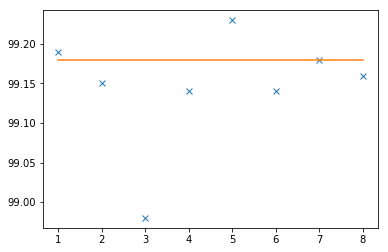

In [14]:
plt_res=np.array(res)
plt.plot(plt_res[:,0], plt_res[:,1], 'x')
plt.plot((minp,maxp),(fp_test_res['accuracy'], fp_test_res['accuracy']))


In [15]:
print("Total execution time (s):", time.time() - start_time)

Total execution time (s): 51398.055698394775
